**Importing Libraries**

In [592]:
#!pip install scikit-optimize

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import statistics 
from sklearn import linear_model
from sklearn.ensemble  import forest
from sklearn import tree
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV



# Reading the data

In [593]:
df = pd.read_csv("Safra_2018-2019.csv")                    
print(df.shape)                

(80000, 11)


### **Data Preparation**

**Renaming columns**

In [594]:
#coverting portuguese columns to english
df = df.rename(columns={"Identificador_Agricultor":"Identifier_Agriculturist","Estimativa_de_Insetos":"Insect_Estimate","Tipo_de_Cultivo":"CultivationType","Tipo_de_Solo":"Soil_Type","Categoria_Pesticida":"Category_Pesticide","Doses_Semana":"Doses_Week","Semanas_Utilizando":"Weeks_Using","Semanas_Sem_Uso":"Weeks_Without","Temporada":"Season","dano_na_plantacao":"damage_in_plantation"}) 

**Data Cleaning**

checking for missing values

In [595]:
#Dropping column Unamed
df = df.iloc[:,1:]  
#Checking the percentage missing values by columns
missing_column = (df.isna().sum()/len(df))*100
print(missing_column)

#Dropping missing
df = df.dropna(axis=0)


Identifier_Agriculturist     0.00000
Insect_Estimate              0.00000
CultivationType              0.00000
Soil_Type                    0.00000
Category_Pesticide           0.00000
Doses_Week                   0.00000
Weeks_Using                 10.06875
Weeks_Without                0.00000
Season                       0.00000
damage_in_plantation         0.00000
dtype: float64


Checking for duplicates

In [596]:
duplicate = df.duplicated().sum()
print(duplicate)#we can see that there are duplicates values

0


Description of the data

In [597]:
#pd.set_option('display.max_columns', None)
print(df.describe())

       Insect_Estimate  CultivationType  ...        Season  damage_in_plantation
count     71945.000000     71945.000000  ...  71945.000000          71945.000000
mean       1401.865230         0.282716  ...      1.896782              0.192049
std         851.165277         0.450323  ...      0.702210              0.455172
min         150.000000         0.000000  ...      1.000000              0.000000
25%         731.000000         0.000000  ...      1.000000              0.000000
50%        1212.000000         0.000000  ...      2.000000              0.000000
75%        1898.000000         1.000000  ...      2.000000              0.000000
max        4097.000000         1.000000  ...      3.000000              2.000000

[8 rows x 9 columns]


Checking for multicollinearity

'\nBY visualising the numerical variables we can \nsee that there are no multicollinearity\n'

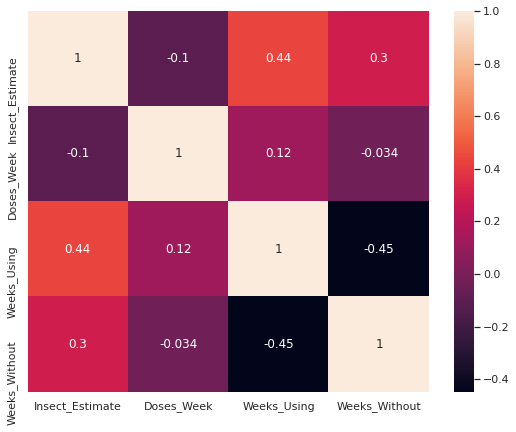

In [598]:
cor = df[["Insect_Estimate","Doses_Week","Weeks_Using","Weeks_Without"]].corr()
sns.heatmap(cor,annot=True)
"""
BY visualising the numerical variables we can 
see that there are no multicollinearity
"""

**Visualsing The Data**

Visualsing Insect_Estimate VS damage_in_plantation

damage_in_plantation
0    1317.262388
1    1842.925261
2    1739.869588
Name: Insect_Estimate, dtype: float64


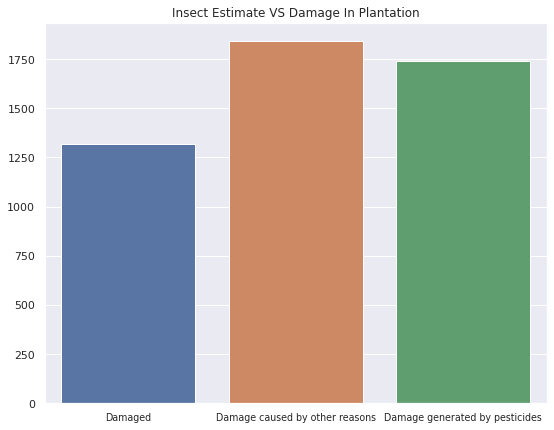

In [599]:
Insect_Estimate  = df.groupby("damage_in_plantation").Insect_Estimate.mean()
print(Insect_Estimate)

x = df["damage_in_plantation"].unique()
height = Insect_Estimate.unique()


fig, ax = plt.subplots()
sns.barplot(x=x,y=height).set_title("Insect Estimate VS Damage In Plantation")
sns.set(rc={'figure.figsize':(9,7)})
ax.set_xticklabels(["Damaged","Damage caused by other reasons","Damage generated by pesticides"],size=9.5)
plt.show()

#We can see that ehen there was no Damage the insect estimate was lower..
#And when there was Damage or Danage caused by pesticide the insect estimate was higher

# We can conclude that the lower the insect estimate the lower the damage


Visualising CultivationType VS damage_in_plantation

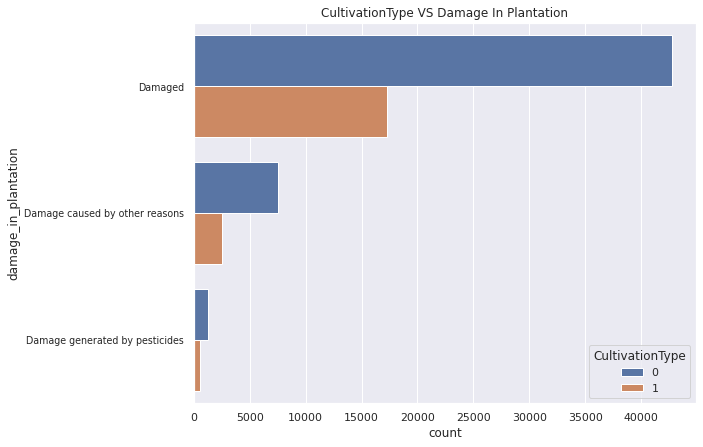

In [600]:
fig, ax = plt.subplots()
sns.countplot(y="damage_in_plantation",hue="CultivationType",data=df).set_title("CultivationType VS Damage In Plantation")
ax.set_yticklabels(["Damaged","Damage caused by other reasons","Damage generated by pesticides"],size=9.5)
plt.show()



#According to the visualisation we can see that majority of the
#CultivationType that were Not Damaged are the 0 type.This trend
#shows that if the classification type = 0 there is very little 
#probability that the crop is damaged

#We can also see that majority of the cllassification type = 0 had majority of the
#Damage caused by other reasons..This trend shows that there is more probality that the 
#classification type = 0 damage will be caused by Damage caused by other resason rather than pesticide

#The visualisation shows that CultivationType 0 had
#more Damage caused by pesticide with a little difference from classification type 1 

# We can see that there is a trend in our classification type  and this will
#be a good feature for our model

Exploring Doses per Week vs damage_in_plantation

damage_in_plantation
0    26.112019
1    24.211911
2    26.082309
Name: Doses_Week, dtype: float64


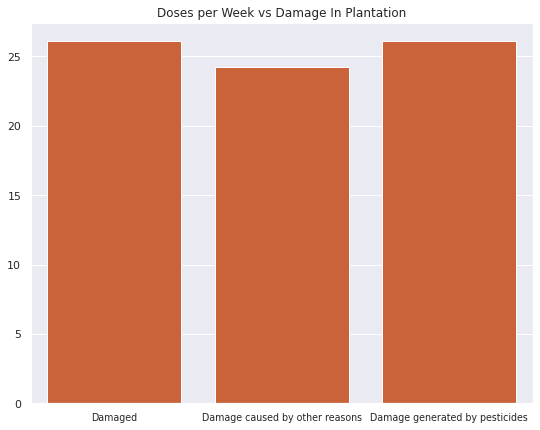

In [601]:
Doses_Week = df.groupby("damage_in_plantation").Doses_Week.mean()
print(Doses_Week)


x = df["damage_in_plantation"].unique()
height = Doses_Week.unique()

fig, ax = plt.subplots()

sns.barplot(x=x,y=height,color="#E25822").set_title("Doses per Week vs Damage In Plantation")
ax.set_xticklabels(["Damaged","Damage caused by other reasons","Damage generated by pesticides"],size=9.5)
plt.show()


# We can see that there is Little/No trend between the Doses per week and the damage_in_plantation.



# Feature Selection - Two Categorical Variable

## feature selection using chi-square test

**Null hypothesis- There is no relationship between two categorical variable**

**Alternatative hypothesis- There is a relationship between two categorical variable**

* The Null hypothesis will be set by default

* A p-value (typically ≤ 0.05) is statistically significant which means the Null hypothesis should be rejected.. If the p-value is (typically > 0.05) the Null hypothesis should be accepted


**#Questions we are going to answer **
* Is there any correlation between the Cultivation Type and Damage In Plantation
* Is there any correlation between Soil_Type and Damage In Plantation
* Is there any correlation between Category_Pesticide and Damage In Plantation
* Is there any correlation between Season and Damage In Plantation

** **Is there any correlation between the Cultivation Type and Damage In Plantation** **


In [602]:
df["CultivationType"].value_counts()

0    51605
1    20340
Name: CultivationType, dtype: int64

In [603]:
#In Chi Square the first thing to be done is to create a Cross Tab(Contingency Table).
#They are used to summaries the relationship between several categorical values

cultitype_Damage_ct = pd.crosstab(df["CultivationType"],df["damage_in_plantation"])
print(cultitype_Damage_ct) 

damage_in_plantation      0     1     2
CultivationType                        
0                     42754  7533  1318
1                     17245  2542   553


In [604]:
#The chi-square test for independence, also called Pearson's chi-square test
#is used to discover if there is a relationship between two categorical variables.


(chi2_statistic, p, dof,_) = stats.chi2_contingency(cultitype_Damage_ct.iloc[0:2,:].values)

#The Chi2 statistic tells the difference exists between your observed counts and
#the counts you would expect if there were no relationship at all in the population.
#The higher the Chi2 statistic value the higher the probability that the observed values are correlated(statistically significant)
print(f'chi2_statistic = {chi2_statistic}')

print(f'P-Value = {p}')

if p <= 0.05:
  print("'Reject Null Hypothesis' The Categorical features are corellated")
elif p > 0.05:
  print("Null Hypothesis Is True")

#We can see that the CultivationType and Damage In Plantation are corellated


chi2_statistic = 54.01364906691389
P-Value = 1.8667455786786662e-12
'Reject Null Hypothesis' The Categorical features are corellated


** **Is there any correlation between Soil_Type and Damage In Plantation** **

In [605]:
#Crosstab
soiltype_Damage_ct = pd.crosstab(df["Soil_Type"],df["damage_in_plantation"])
print(soiltype_Damage_ct)


damage_in_plantation      0     1     2
Soil_Type                              
0                     32279  5738  1078
1                     27720  4337   793


In [606]:
(chi2_statistic, p, dof,_) = stats.chi2_contingency(soiltype_Damage_ct.iloc[0:2,:].values)

In [607]:
print(f'chi2_statistic = {chi2_statistic}')

print(f'P-Value = {p}')

if p <= 0.05:
  print("'Reject Null Hypothesis' The Categorical features are corellated")
elif p > 0.05:
  print("Null Hypothesis Is True")

chi2_statistic = 42.88739997208629
P-Value = 4.865409787739305e-10
'Reject Null Hypothesis' The Categorical features are corellated


** **Is there any correlation between Category_Pesticide and Damage In Plantation** **

In [608]:
#Crosstab
catpes_Damage_ct = pd.crosstab(df["Category_Pesticide"],df["damage_in_plantation"])
print(catpes_Damage_ct)

damage_in_plantation      0     1     2
Category_Pesticide                     
1                        94   455   126
2                     45801  4937   553
3                     14104  4683  1192


In [609]:
(chi2_statistic, p, dof,_) = stats.chi2_contingency(catpes_Damage_ct.iloc[0:3,:].values)

In [610]:
print(f'chi2_statistic = {chi2_statistic}')

print(f'P-Value = {p}')

if p <= 0.05:
  print("'Reject Null Hypothesis' The Categorical features are corellated")
elif p > 0.05:
  print("Null Hypothesis Is True")

chi2_statistic = 6341.7572830388535
P-Value = 0.0
'Reject Null Hypothesis' The Categorical features are corellated


** **Is there any correlation between Season and Damage In Plantation** **




In [611]:
#Crosstab
sea_Damage_ct = pd.crosstab(df["Season"],df["damage_in_plantation"])
print(sea_Damage_ct)

damage_in_plantation      0     1    2
Season                                
1                     18205  3091  538
2                     29744  4982  977
3                     12050  2002  356


In [612]:
(chi2_statistic, p, dof,_) = stats.chi2_contingency(sea_Damage_ct.iloc[0:3,:].values)

In [613]:
print(f'chi2_statistic = {chi2_statistic}')

print(f'P-Value = {p}')

if p <= 0.05:
  print("'Reject Null Hypothesis' The Categorical features are corellated")
elif p > 0.05:
  print("Null Hypothesis Is True")

"""
The Null Hypothesis Is True which means Season is not correlated with the Damage In Plantation
which should be dropped
"""

chi2_statistic = 5.713111702940036
P-Value = 0.2216221591911207
Null Hypothesis Is True


'\nThe Null Hypothesis Is True which means Season is not correlated with the Damage In Plantation\nwhich should be dropped\n'

# Dimension Reduction

In [614]:
#Dropping Features with low relationship and irelevant Features
# We will be dropping the Doses per week variable,Identifier_Agriculturist,Season

df = df.drop(["Season","Identifier_Agriculturist"],axis=1)
print(df.shape)

(71945, 8)


# **Modelling**


**Declaring independent and Target Variable**

In [615]:
x = df.drop("damage_in_plantation",axis=1)
y = df["damage_in_plantation"]

Spltting the dataframe into training and testing sample of 80% and 20% respectively.


In [616]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=0)


Using Cross Validation to find the algorithm that gives the best performance

In [617]:
log = linear_model.LogisticRegression()
fo =  forest.RandomForestClassifier()
tr = tree.DecisionTreeClassifier()
sv = svm.SVC()
xg = xgb.XGBClassifier()

In [618]:
#fitting the models to cross validation score to find the best model

import warnings
warnings.filterwarnings('ignore')

log_score = cross_val_score(log,x_train,y_train)

fo_score = cross_val_score(fo,x_train,y_train)

dtree_score = cross_val_score(tr,x_train,y_train)

sv_score = cross_val_score(sv,x_train,y_train)

xg_score = cross_val_score(xg,x_train,y_train)

In [619]:
df_score = pd.DataFrame({"model":["Logistic Regression","Random Forest Classifier","Decision Tree Classifier","support vector machine","xgboost classifier"],"score":[statistics.mean(log_score),statistics.mean(fo_score),statistics.mean(dtree_score),statistics.mean(sv_score),statistics.mean(xg_score)]})
print(df_score)
#We can see that xgboost classifier gave the best score

                      model     score
0       Logistic Regression  0.833901
1  Random Forest Classifier  0.814963
2  Decision Tree Classifier  0.747290
3    support vector machine  0.834057
4        xgboost classifier  0.842154


#Hyperparameter Tuning Using Using BayesSearchCV
Finding the hyperparameter values of a learning algorithm that produces the best result

In [620]:
#Checking initial model score
model = xgb.XGBClassifier()
model = model.fit(x_train,y_train)
original_score = model.score(x_test,y_test)
print(f'Original Score = {original_score}')

Original Score = 0.8424490930571965


Optimizing parameters

In [621]:
#Finding the best parameter
# model = xgb.XGBClassifier()
# param = {"max_depth":[3,4,5,8,9],"subsample":[0.6,0.7,1.0],"colsample_bytree":[0.6,0.9,1.0],"min_child_weight":[1,2,3,6,1],"learning_rate":[0.01,0.1,1.0,0.3,0.5]}
# search = BayesSearchCV(model,param,scoring="accuracy")
# search = search.fit(x_train,y_train)
# print(search.best_params_)

# search.best_params_ =  OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.5), ('max_depth', 3), ('min_child_weight', 1), ('subsample', 1.0)])

In [622]:
#Optimized model
model = xgb.XGBClassifier(colsample_bytree=1.0,learning_rate=0.5,max_depth=3,min_child_weight=1,subsample=1.0)
model = model.fit(x_train,y_train)
original_score = model.score(x_test,y_test)
print(f'New Score = {original_score}')

New Score = 0.8458544721662381


# **Predicting 2020 Harvest **
whether the harvest will be healthy, harmed by pesticides, or harmed for other reasons.**

In [623]:
pred = pd.read_csv("Safra_2020.csv")
print(pred.shape)

(8858, 10)


**Data Preparation**

In [624]:
#coverting portuguese columns to english
pred = pred.rename(columns={"Identificador_Agricultor":"Identifier_Agriculturist","Estimativa_de_Insetos":"Insect_Estimate","Tipo_de_Cultivo":"CultivationType","Tipo_de_Solo":"Soil_Type","Categoria_Pesticida":"Category_Pesticide","Doses_Semana":"Doses_Week","Semanas_Utilizando":"Weeks_Using","Semanas_Sem_Uso":"Weeks_Without","Temporada":"Season","dano_na_plantacao":"damage_in_plantation"}) 

In [625]:
#Dropping column
pred = pred.iloc[:,1:]  

#Checking the percentage missing values by columns
missing_column = (pred.isna().sum()/len(pred))*100
print(missing_column)
#Dropping missing
pred = pred.dropna(axis=0)

Identifier_Agriculturist     0.000000
Insect_Estimate              0.000000
CultivationType              0.000000
Soil_Type                    0.000000
Category_Pesticide           0.000000
Doses_Week                   0.000000
Weeks_Using                 10.668322
Weeks_Without                0.000000
Season                       0.000000
dtype: float64


In [626]:
pred = pred.drop(["Season","Identifier_Agriculturist"],axis=1)
print(pred.shape)


(7913, 7)


predicting 2020 harvest

In [627]:
ypred = model.predict(pred)
pred["Predicted_Damage_In_Plantation"] = ypred
print(pred.to_csv("Predicted_Damage_In_Plantation.csv"))

None
